In [1]:
# This is a Python 2 script

The goal is measuring temperature and density of embedded protostars/cores with submm data.  This method is widely used in the literature since it does not involve complicated RT modeling.  Blackbody function fits a single temperature component with choice of dust model.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import astropy.constants as const
c = const.c.cgs.value
h = const.h.cgs.value
k = const.k_B.cgs.value
pc = const.pc.cgs.value
AU = const.au.cgs.value
MS = const.M_sun.cgs.value
mh = const.m_p.cgs.value + const.m_e.cgs.value

/Users/yaolun/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Weingartner & Draine
# dustfile = ascii.read('/Users/yaolun/Google Drive/dust_model/Weingartner_Draine/kext_albedo_WD_MW_5.5A_30_D03_nocomment.all',
#                       header_start=64, data_start=67)

# Ossenkopf & Hennings
# dustfile = ascii.read('/Users/yaolun/programs/misc/oh5_hyperion.txt', names=['nu', 'albedo','chi','g'])

# Use Neal's original version of OH5 dust
dustfile = np.genfromtxt('/Users/yaolun/Google Drive/dust_model/Dust_OH5_Evans_Shirley/sigma.oh5.ref', 
                          skip_header=2, skip_footer=1).T

BHR71

E(B-V) = 1.7790 +/-  0.1581 (S&F 2011) and	2.0686 +/-  0.1839 (SFD 1998)

if Rv = 5.5

Av = 9.78 & 11.38

$S_{\nu} = B_{\nu}(T_{dust}) (1-e^{-\tau_{\nu}})\Omega_{beam, \nu}$

In optically thin limit

$S_{\nu} = B_{\nu}(T_{dust})\tau_{\nu}\Omega_{beam, \nu}$

assume $\tau_{\nu} = N_{dust} \sigma_{d} Q_{ext}$

$\sigma_{d}$ is the geometric cross-section of dust grains, and $Q_{ext}$ is the dimensionless extinction efficiency

take $\sigma_{d} Q_{ext} = \sigma_{ext} = \sigma_{scat}+\sigma_{abs}$

then $S_{\nu} = B_{\nu}(T_{dust})\sigma_{ext}N_{dust}\Omega_{beam, \nu}$

In [3]:
# read in observations
import sys
sys.path.append('/Users/yaolun/programs/misc/hyperion/')
from get_obs import get_obs
obs = get_obs('/Users/yaolun/bhr71/best_calibrated/', obj='BHR71')  # flux in Jy

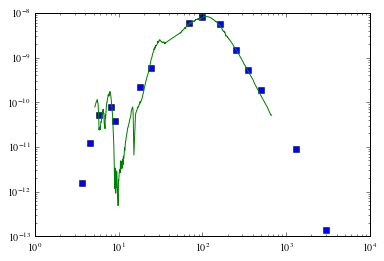

In [4]:
plt.plot(obs['phot'][0], obs['phot'][1]*1e-23*(c/obs['phot'][0]/1e-4), 's')
plt.plot(obs['spec'][0], obs['spec'][1]*1e-23*(c/obs['spec'][0]/1e-4), 'g')
plt.xscale('log')
plt.yscale('log')

In [5]:
def bbfunc(omegab, kappa):
    def bbfunc2(nu, *p):
        tdust = p[0]
        Nd = p[1]
        
        # kappa in cm2 of dust
        # nd = 1/cm2
        import astropy.constants as const
        import numpy as np

        h = const.h.cgs.value
        c = const.c.cgs.value
        k = const.k_B.cgs.value

        bb = 2.*h*nu**3/c**2 / (np.exp(h*nu/k/tdust)-1)
        
        return bb * kappa * Nd * omegab
    return bbfunc2

In [6]:
def bbfunc2(nu, omegab, kappa, *p):
    tdust = p[0]
    Nd = p[1]

    # kappa in cm2/g of dust
    # nd = g/cm2
    import astropy.constants as const
    import numpy as np

    h = const.h.cgs.value
    c = const.c.cgs.value
    k = const.k_B.cgs.value

    bb = 2.*h*nu**3/c**2 / (np.exp(h*nu/k/tdust)-1)

    return bb * kappa * Nd * omegab

In [7]:
freq = c/1.3e-1
td = 19.6
bb = 2.*h*freq**3/c**2 / (np.exp(h*freq/k/td)-1)
print bb

2.38293219779e-13


In [19]:
# get the kappa_nu from dust model
# the unit is cm2/g
# this part depends on the format of input dust model
# kappa = (1-dustfile['albedo']) * dustfile['chi']
# kappa = dustfile['chi']
# Neal's version of OH5 dust
kappa = (dustfile[0,:]+dustfile[1,:])
nu_kappa = c/dustfile[3,:]*1e4

# # for oh5, md = 1/(1.0395087779657002e14)
md = 1/(1.0395087779657002e14)
# Av = 11.38

# nu = c/obs['phot'][0][(obs['phot'][0] > 200) & (obs['phot'][0] < 1400)]/1e-4
# f_phot = obs['phot'][1][(obs['phot'][0] > 200) & (obs['phot'][0] < 1400)]/nu
# f_phot_err = obs['phot'][2][(obs['phot'][0] > 200) & (obs['phot'][0] < 1400)]/nu
# aper = np.array([90.0, 35.4, 47.9, 46.0])

# take down to 70 um
trimmer = (obs['phot'][0] >= 160) & (obs['phot'][0] < 1400)
nu = c/obs['phot'][0][trimmer]/1e-4
f_phot = obs['phot'][1][trimmer]*1e-23
f_phot_err = obs['phot'][2][trimmer]*1e-23

sorter = np.argsort(nu)
nu = nu[sorter]
f_phot = f_phot[sorter]
f_phot_err = f_phot_err[sorter]

# load aperture
aperture = ascii.read('/Users/yaolun/bhr71/best_calibrated/aperture.txt')
aper = []
for wl in obs['phot'][0][trimmer]:
    if wl in aperture['wavelength(um)']:
        aper.append(aperture['aperture(arcsec)'][aperture['wavelength(um)'] == wl][0])
    else:
        print 'No aperture found for %f um' % wl
        aper_dum = raw_input('What is the aperture size?')
        aper.append(aper_dum)
aper = np.array(aper)
# aper = np.array([31.8, 31.8, 31.8, 35.4, 47.9, 46.0, 90.0])

omegab = np.pi*(aper/2)**2/4.25e10

# interpolate kappa
from scipy.interpolate import interp1d
f = interp1d(nu_kappa, kappa)
kappa_int = f(nu)

In [20]:
from scipy.optimize import curve_fit
p = curve_fit(bbfunc(omegab, kappa_int), nu, f_phot, sigma=f_phot_err, p0=[50, 1e22])
print p
perr = np.sqrt(np.diag(p[1]))
print perr
# print p[0]+perr, p[0]-perr

(array([  2.46025771e+01,   7.79405706e+10]), array([[  1.32664023e+01,  -1.50971584e+11],
       [ -1.50971584e+11,   1.74873307e+21]]))
[  3.64230727e+00   4.18178559e+10]


In [21]:
p[0][1]*md/mh

4.4802393207102243e+20

In [22]:
area = (90.*200/2*AU)**2*np.pi
print p[0][1]*area * md *100 /MS * 0.315*pc/(90*200./2*AU)
print perr[1]*area * md *100 /MS * 0.315*pc/(90*200./2*AU)

15.4973590733
8.31487789751


In [23]:
# evaluate RJ limit
h = const.h.cgs.value
c = const.c.cgs.value
k = const.k_B.cgs.value
h*nu/k/p[0][0]
# p[0]+perr

array([ 0.44985186,  1.16961484,  1.67087834,  2.33922967,  3.65504636])

[ 90.   31.8  31.8  31.8  35.4  47.9  46. ]
[ 1300.    70.   100.   160.   250.   350.   500.]


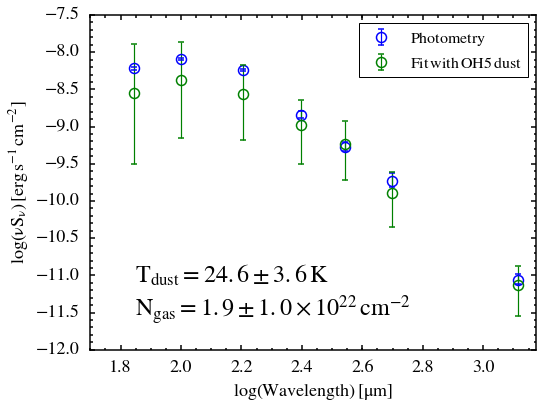

In [25]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

obs_trimmer = (obs['phot'][0] > 60) & (obs['phot'][0] < 1400)
nu = c/obs['phot'][0][obs_trimmer]/1e-4
f_phot = obs['phot'][1][obs_trimmer]*1e-23
f_phot_err = obs['phot'][2][obs_trimmer]*1e-23
kappa_int = f(nu)

# re-get the aperture
aper = []
for wl in obs['phot'][0][obs_trimmer]:
    if wl in aperture['wavelength(um)']:
        aper.append(aperture['aperture(arcsec)'][aperture['wavelength(um)'] == wl][0])
    else:
        print 'No aperture found for %f um' % wl
        aper_dum = raw_input('What is the aperture size?')
        aper.append(aper_dum)
aper = np.array(aper)

print aper
print c/nu*1e4

omegab = np.pi*(aper/2)**2/4.25e10

obs_yerr_hi = np.log10(f_phot*nu+f_phot_err*nu)-np.log10(f_phot*nu)
obs_yerr_low = np.log10(f_phot*nu)-np.log10(f_phot*nu-f_phot_err*nu)

obs_plot = ax.errorbar(np.log10(c/nu*1e4), np.log10(f_phot*nu), yerr=[obs_yerr_hi, obs_yerr_low], 
                       fmt='o', markersize=10, markeredgewidth=1.5,
                       mec='b', ecolor='b', color='None', elinewidth=1.2, capthick=1.2, barsabove=True)

yerr_hi = np.log10(bbfunc2(nu, omegab, kappa_int, *p[0]+perr)*nu) - np.log10(bbfunc2(nu, omegab, kappa_int, *p[0])*nu)
yerr_low = np.log10(bbfunc2(nu, omegab, kappa_int, *p[0])*nu) - np.log10(bbfunc2(nu, omegab, kappa_int, *p[0]-perr)*nu)

fit = ax.errorbar(np.log10(c/nu*1e4), np.log10(bbfunc2(nu, omegab, kappa_int, *p[0])*nu),
                  yerr=[yerr_low, yerr_hi], fmt='o', linestyle='-', markersize=10, markeredgewidth=1.5,
                  color='None', mec='g',ecolor='g', elinewidth=1.2, capthick=1.2, barsabove=True)

ax.legend([obs_plot, fit], [r'$\rm{Photometry}$', r'$\rm{Fit\,with\,OH5\,dust}$'],
          loc='best', numpoints=1, fontsize=16)

ax.text(0.1, 0.2, r'$\rm{T_{dust}= %3.1f \pm %3.1f \,K}$' % (p[0][0], perr[0]), transform=ax.transAxes, fontsize=24)
# expo = np.floor(np.log10(p[0][1]))
# ax.text(0.1, 0.1, r'$\rm{N_{dust}= %2.1f \pm %2.1f \times 10^{%d}\,cm^{-2}}$' % (p[0][1]/10**expo, perr[1]/10**expo, expo), 
#         transform=ax.transAxes, fontsize=24)
ngas = p[0][1]*md*100/mh/2.37
ngas_err = perr[1]*md*100/mh/2.37
expo = np.floor(np.log10(ngas))
ax.text(0.1, 0.1, r'$\rm{N_{gas}= %2.1f \pm %2.1f \times 10^{%d}\,cm^{-2}}$' % (ngas/10**expo, ngas_err/10**expo, expo), 
        transform=ax.transAxes, fontsize=24)

ax.set_xlim([np.log10(50), np.log10(1500)])

[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=10,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=10,length=2.5)
ax.set_xlabel(r'$\rm{log(Wavelength)\,[\mu m]}$', fontsize=18)
ax.set_ylabel(r'$\rm{log(\nu S_{\nu})\,[erg\,s^{-1}\,cm^{-2}]}$', fontsize=18)

fig.savefig('/Users/yaolun/bhr71/greybb_fit_ge160.pdf', format='pdf', dpi=300, bbox_inches='tight')